# Energy Consumption Forecast using XGBoost Algorithm

### About the data 
**This dataset is from Kaggle**

**PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [3]:
# Verifying the data type
df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

**Datetime columns is object type, changing it to datetime type and setting the Datetime column as the index**

In [4]:
#df["Datetime"] = pd.to_datetime(df["Datetime"])
#df.dtypes

In [5]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Verifying if the dataset is properly ordered by dates in ascending order

In [6]:
print("The earliest date is:", df.index.min())

The earliest date is: 2002-01-01 01:00:00


**Sorting the data in ascending order to ensure proper chronological splitting for training and testing**

In [7]:
# Ensure the DataFrame is sorted by datetime index
df = df.sort_index()
df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


**Visualizing the data**

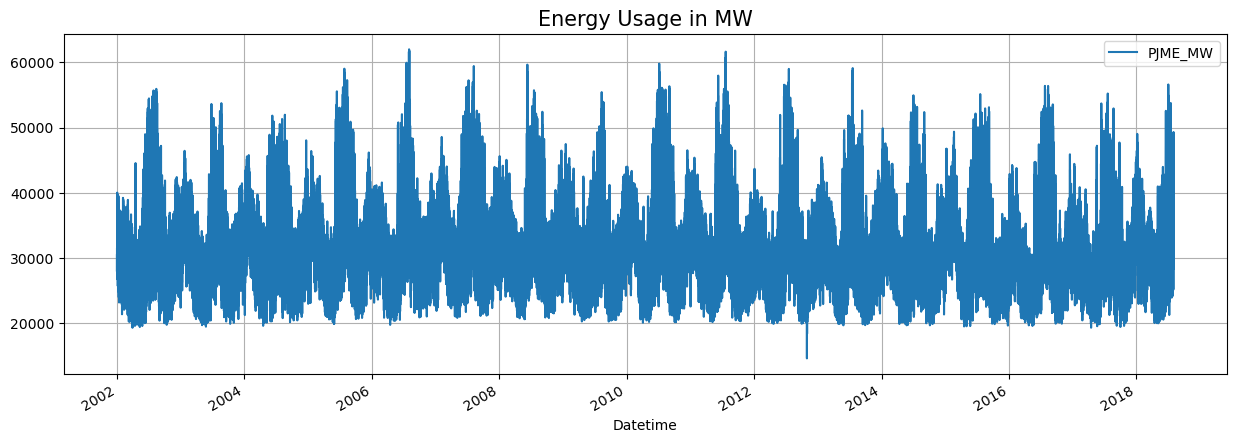

In [8]:
df.plot(figsize=(15,5))
plt.title("Energy Usage in MW", fontsize=15)
plt.grid(True)
plt.show()

## Feature engineering

**Crearing new inputs from raw data**

In [9]:
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df.head()

,PJME_MW,month,day,hour,day_of_week
Datetime,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1
2002-01-01 02:00:00,29265.0,1,1,2,1
2002-01-01 03:00:00,28357.0,1,1,3,1
2002-01-01 04:00:00,27899.0,1,1,4,1
2002-01-01 05:00:00,28057.0,1,1,5,1


## Splitting the dataset into Train and Test sets

**Creating features and labels**

In [10]:
X = df.drop("PJME_MW", axis=1)
y = df["PJME_MW"]

In [11]:
# Showing the features
X.head()

,month,day,hour,day_of_week
Datetime,,,,
2002-01-01 01:00:00,1,1,1,1
2002-01-01 02:00:00,1,1,2,1
2002-01-01 03:00:00,1,1,3,1
2002-01-01 04:00:00,1,1,4,1
2002-01-01 05:00:00,1,1,5,1


In [12]:
# Showring the labels which is the actual consumption of energy
pd.DataFrame(y).head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


**Function to split the data into train and test sets**

In [13]:
def split_data(features, labels, percent=80):

    # Splitting the data into features, labels, train and test sets
    split = int(percent/100 * len(features))
    
    X = features
    y = labels
    
    X_train = X.iloc[:split]
    y_train = y.iloc[:split]
    
    X_test = X.iloc[split:]
    y_test = y.iloc[split:]

    return X_train, y_train, X_test, y_test

In [14]:
# Splitting the dataset in to 80% for training and 20% for testing
X_train, y_train, X_test, y_test = split_data(X, y, 80)

In [15]:
print("Lend of training set:", len(X_train))
print("Lend of testing set:", len(X_test))

Lend of training set: 116292
Lend of testing set: 29074


In [16]:
pd.DataFrame(y_train)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2015-04-09 10:00:00,33082.0
2015-04-09 11:00:00,33285.0
2015-04-09 12:00:00,33148.0


In [17]:
pd.DataFrame(y_test).head()

,PJME_MW
Datetime,
2015-04-09 15:00:00,32204.0
2015-04-09 16:00:00,32049.0
2015-04-09 17:00:00,32209.0
2015-04-09 18:00:00,32707.0
2015-04-09 19:00:00,33012.0


## Plotting energy consumption for training and test sets

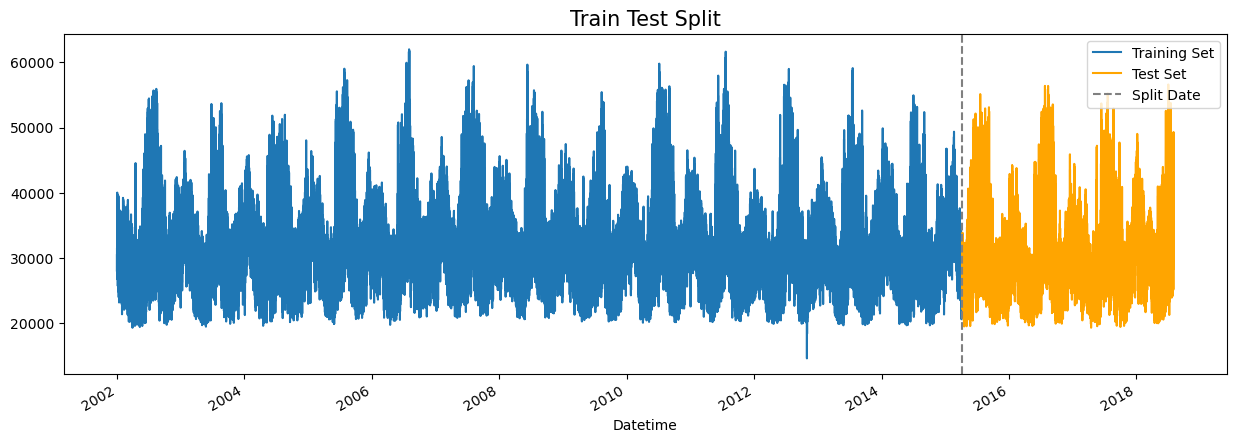

In [18]:
# Plot the training and test sets
date_of_split = "2015-04-09 14:00:00"

fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label="Training Set")
y_test.plot(ax=ax, label="Test Set", color="orange")
ax.axvline(date_of_split, ls="--", color="gray", label="Split Date")
ax.legend()
plt.title("Train Test Split", fontsize=15)
plt.show()

**Zooming in to better visulize the energy consumption**

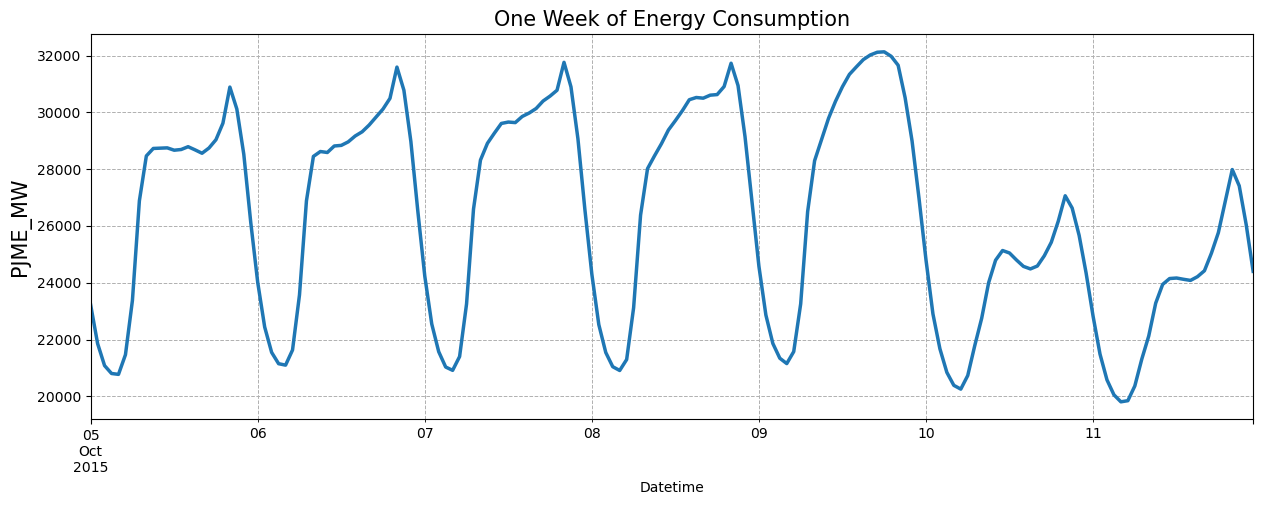

In [19]:
#Ploting one week of energy consumption
df["PJME_MW"].loc[(df.index >= "2015-10-05") & (df.index < "2015-10-12")].plot(figsize=(15, 5), linewidth=2.5)
plt.title("One Week of Energy Consumption", fontsize=15)
plt.ylabel("PJME_MW", fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()

### Note: Before we start creating the model we are going to do some exploratory data analysis (EDA).

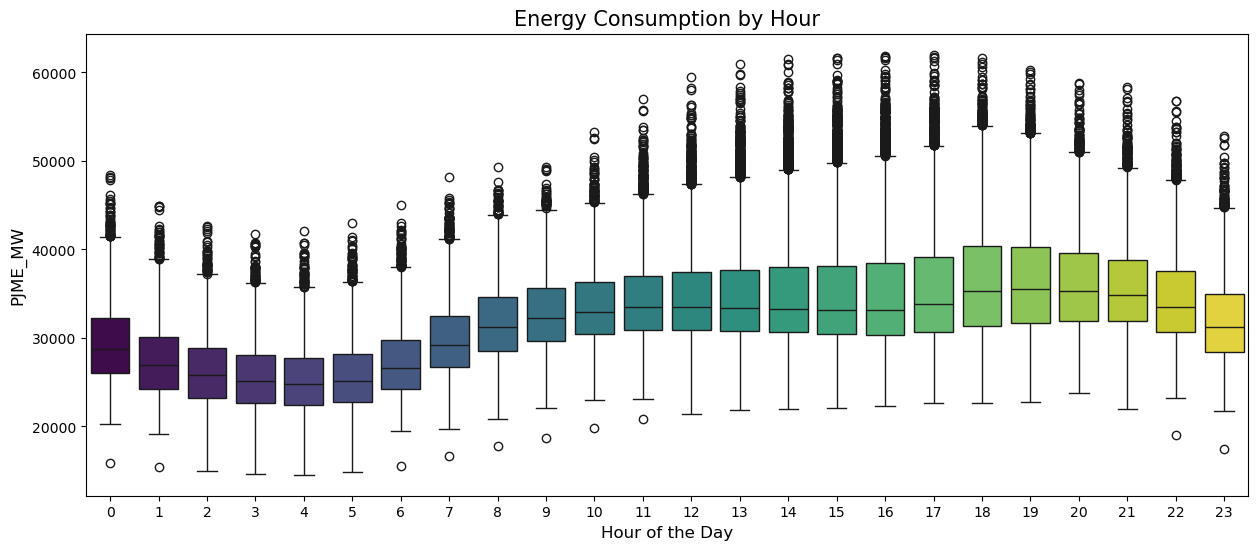

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x=df.index.hour, y=df["PJME_MW"], hue=df.index.hour, palette="viridis", ax=ax, dodge=False, legend=False)
ax.set_title("Energy Consumption by Hour", fontsize=15)
ax.set_xlabel("Hour of the Day", fontsize=12)
ax.set_ylabel("PJME_MW", fontsize=12)
plt.show()

**In the plot above we can observe patterns where energy consumption is higher during the working hours but it peaks right after from 17:00 to 21:00 hour**

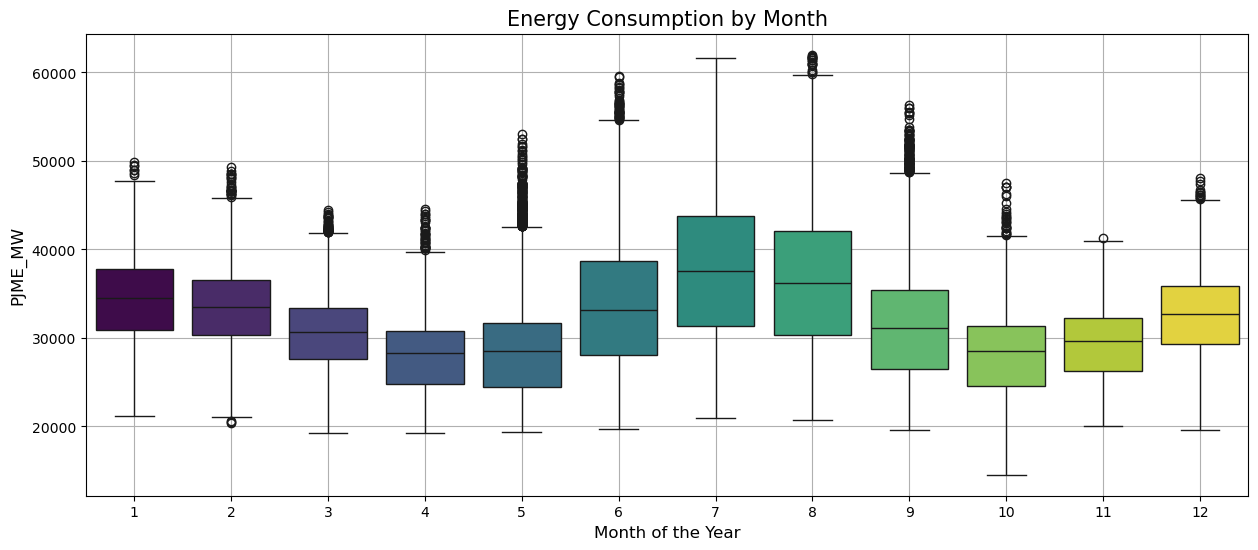

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x=df.index.month, y=df["PJME_MW"], hue=df.index.month, palette="viridis", ax=ax, dodge=False, legend=False)
ax.set_title("Energy Consumption by Month", fontsize=15)
ax.set_xlabel("Month of the Year", fontsize=12)
ax.set_ylabel("PJME_MW", fontsize=12)
plt.grid(True)
plt.show()

**In the plot above we can see seasonal patterns where energy demand fluctuates based on the time of year**

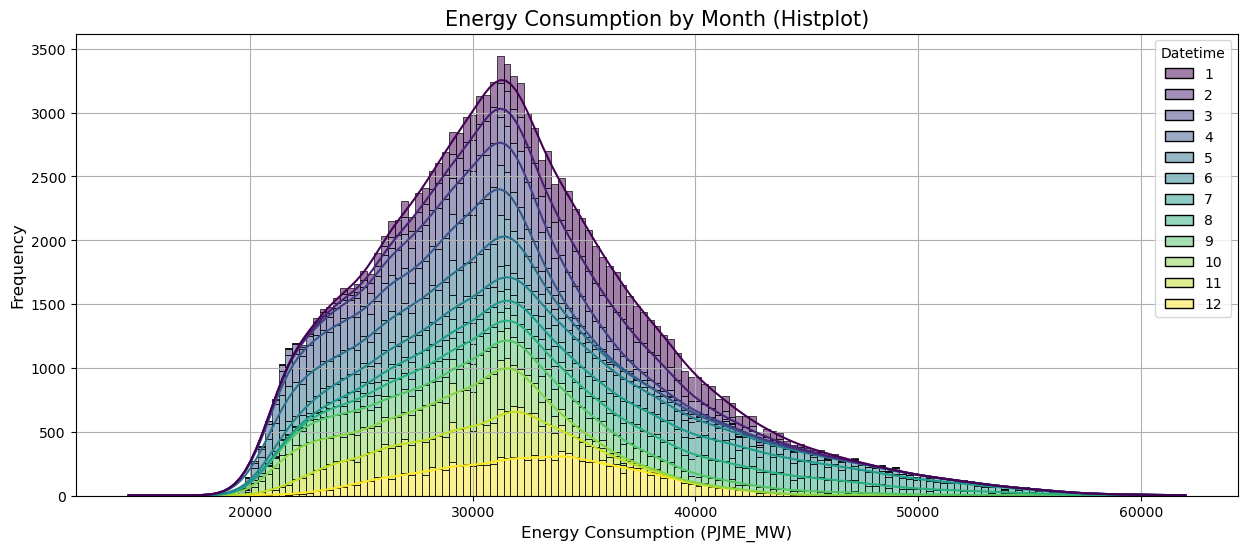

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=df, x="PJME_MW", hue=df.index.month, kde=True, palette="viridis", multiple="stack", ax=ax)
ax.set_title("Energy Consumption by Month (Histplot)", fontsize=15)
ax.set_xlabel("Energy Consumption (PJME_MW)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

**In the histogram above the frequency peaks between 30,000 and 40,000 MW**

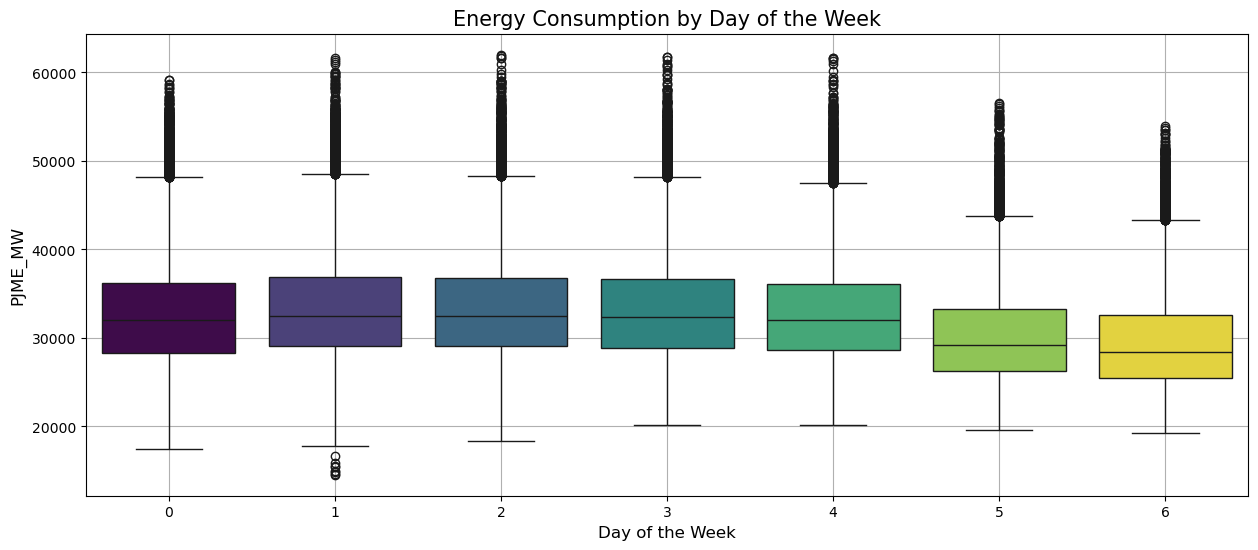

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df, x=df.index.dayofweek, y=df["PJME_MW"], hue=df.index.dayofweek, palette="viridis", ax=ax, dodge=False, legend=False)
ax.set_title("Energy Consumption by Day of the Week", fontsize=15)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("PJME_MW", fontsize=12)
plt.grid(True)
plt.show()

**In the boxplot above we can observe the days with the least energy consumption are on weekends**

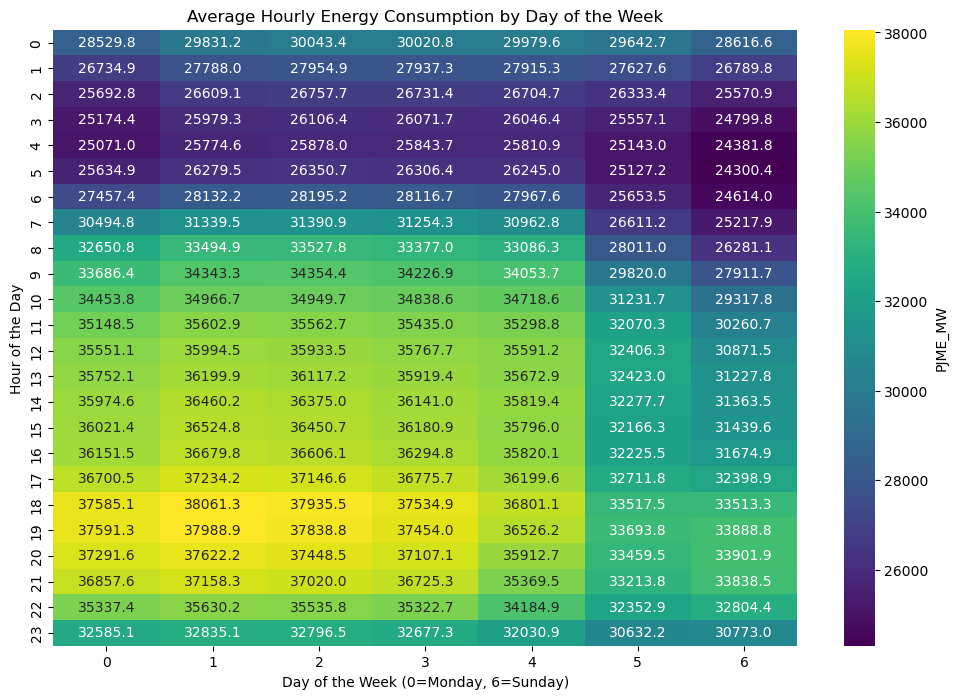

In [24]:
pivot_table = df.pivot_table(values="PJME_MW", index="hour", columns="day_of_week", aggfunc="mean")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".1f", cbar_kws={"label": "PJME_MW"})
plt.title("Average Hourly Energy Consumption by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Hour of the Day")
plt.show()

**Key Observations from the Pivot Table:**

- Energy consumption is generally higher on weekdays compared to weekends.
- Peak usage occurs between 18:00 and 21:00 on weekdays, indicating high evening demand.
- Consumption drops on weekends, showing a clear difference in usage patterns.
- The lowest levels of energy consumption are observed from midnight to 6:00 AM.

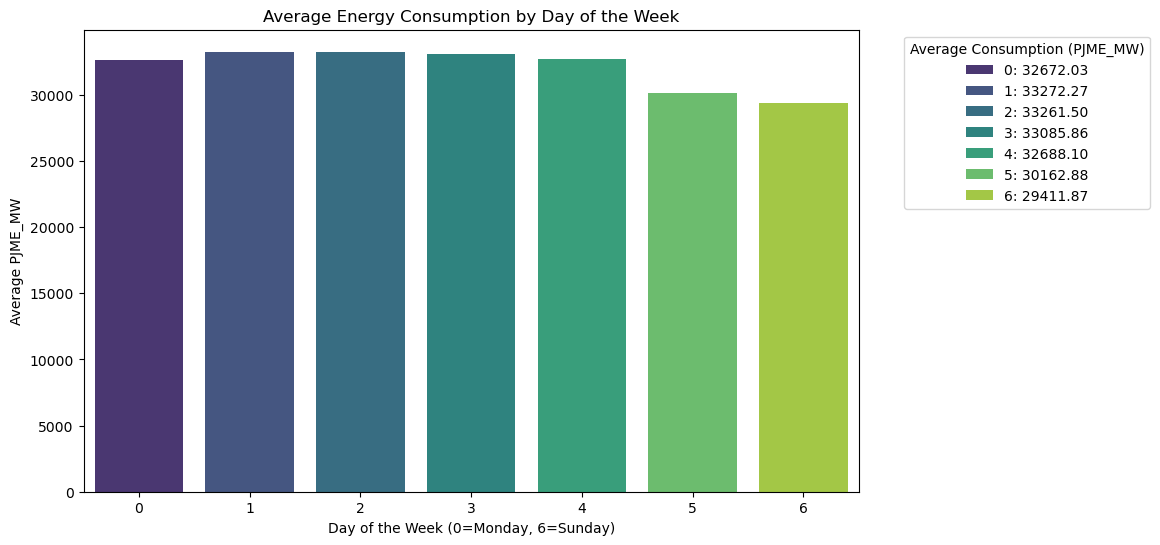

In [25]:
# Calculate the daily average energy consumption by day of the week
daily_avg = df.groupby(df.index.dayofweek)["PJME_MW"].mean()

# Create a DataFrame with day of the week and average consumption
daily_avg_df = pd.DataFrame({
    "Day Of Week": daily_avg.index,
    "PJME_MW": daily_avg.values,
    "Label": [f"{day}: {value:.2f}" for day, value in zip(daily_avg.index, daily_avg.values)]
})

# Plotting the average energy consumption for each day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x="Day Of Week", y="PJME_MW", hue="Label", data=daily_avg_df, palette="viridis", dodge=False)
plt.title("Average Energy Consumption by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Average PJME_MW")

# Position the legend outside the plot to prevent overlap
plt.legend(title="Average Consumption (PJME_MW)", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

**In the bar plot above, we can see the average energy consumption for each day of the week**

In [26]:
daily_avg_df

,Day Of Week,PJME_MW,Label
0,0,32672.028420,0: 32672.03
1,1,33272.265746,1: 33272.27
2,2,33261.497498,2: 33261.50
3,3,33085.857727,3: 33085.86
4,4,32688.097688,4: 32688.10
5,5,30162.880588,5: 30162.88
6,6,29411.869930,6: 29411.87


## Model Creation

**First model**

In [27]:
model_1 = xgb.XGBRegressor(n_estimators=500)
model_1.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

[0]	validation_0-rmse:5461.79069
[50]	validation_0-rmse:3828.11059
[100]	validation_0-rmse:3924.35291
[150]	validation_0-rmse:3999.14321
[200]	validation_0-rmse:4039.32775
[250]	validation_0-rmse:4075.02665
[300]	validation_0-rmse:4099.61661
[350]	validation_0-rmse:4145.10442
[400]	validation_0-rmse:4164.69252
[450]	validation_0-rmse:4181.02785
[499]	validation_0-rmse:4193.79817


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Note:** The model_1 is the simpliest model, still it starts overfitting after 200 trees**

**Forecast with the First Model**

In [28]:
pred_1 = model_1.predict(X_test)
pred_1 = pd.DataFrame(pred_1, index=X_test.index, columns=["predictions"])
pred_1

,predictions
Datetime,
2015-04-09 15:00:00,30860.404297
2015-04-09 16:00:00,30567.919922
2015-04-09 17:00:00,30662.154297
2015-04-09 18:00:00,30685.791016
2015-04-09 19:00:00,30468.078125
...,...
2018-08-02 20:00:00,49658.789062
2018-08-02 21:00:00,49368.113281
2018-08-02 22:00:00,47502.109375


**Merging the predictions into original dataframe to plot the prediction overlapping them over the real values**

In [29]:
df2 = pd.DataFrame(y_test).merge(pred_1, how="left", left_index=True, right_index=True)
df2

,PJME_MW,predictions
Datetime,,
2015-04-09 15:00:00,32204.0,30860.404297
2015-04-09 16:00:00,32049.0,30567.919922
2015-04-09 17:00:00,32209.0,30662.154297
2015-04-09 18:00:00,32707.0,30685.791016
2015-04-09 19:00:00,33012.0,30468.078125
...,...,...
2018-08-02 20:00:00,44057.0,49658.789062
2018-08-02 21:00:00,43256.0,49368.113281
2018-08-02 22:00:00,41552.0,47502.109375


**Plotting the predictions over the real values of energy consumption**

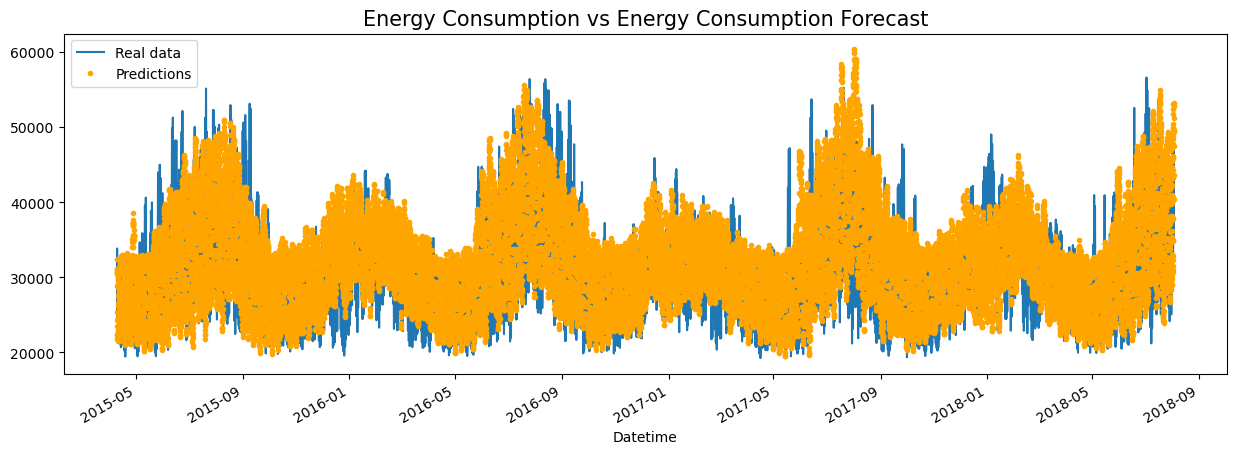

In [30]:
ax = df2["PJME_MW"].plot(figsize=(15, 5))
df2["predictions"].plot(ax=ax, style=".", color="orange")
ax.set_title("Energy Consumption vs Energy Consumption Forecast", fontsize=15)
plt.legend(["Real data", "Predictions"])
plt.show()

**Zooming in to better visualized the energy consumption forecast**

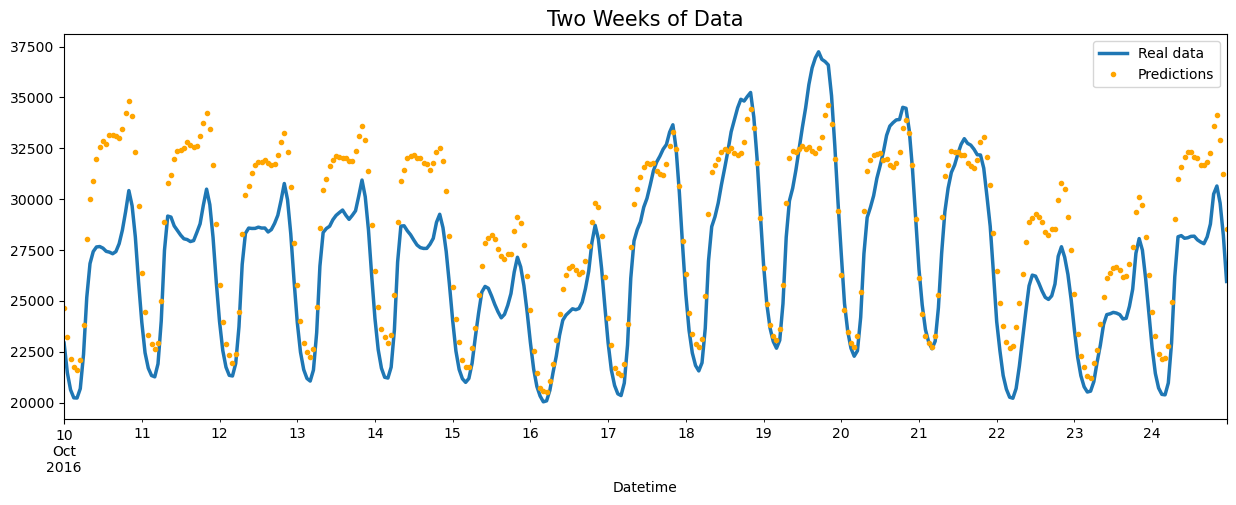

In [31]:
ax = df2["PJME_MW"].loc[(df2.index >= "2016-10-10") & (df2.index < "2016-10-25")].plot(figsize=(15, 5), linewidth=2.5)
df2["predictions"].loc[(df2.index >= "2016-10-10") & (df2.index < "2016-10-25")].plot(ax=ax, style=".", color="orange")
plt.title("Two Weeks of Data", fontsize=15)
plt.legend(["Real data", "Predictions"])
plt.show()

**Evaluating the model_1**

In [32]:
from sklearn import metrics

**MAE**

In [44]:
mae = metrics.mean_absolute_error(y_test, pred_1)
print(f"Predictions Mean Absolute Error: {mae:0.3f}")

Predictions Mean Absolute Error: 3242.956


**MAPE**

In [50]:
mape = metrics.mean_absolute_percentage_error(y_test, pred_1)
print(f"Predictons Mean Absolute Percentage Error: {mape:0.3f}")

Predictons Mean Absolute Percentage Error: 0.104


In [39]:
evaluation_df = df2
evaluation_df["error"] = np.abs(df2["PJME_MW"] - df2["predictions"])
evaluation_df["error_%"] = (evaluation_df["error"] / evaluation_df["PJME_MW"]) * 100
evaluation_df["date"] = df2.index.date
evaluation_df.head()

,PJME_MW,predictions,error,error_%,date
Datetime,,,,,
2015-04-09 15:00:00,32204.0,30860.404297,1343.595703,4.172139,2015-04-09
2015-04-09 16:00:00,32049.0,30567.919922,1481.080078,4.621299,2015-04-09
2015-04-09 17:00:00,32209.0,30662.154297,1546.845703,4.802526,2015-04-09
2015-04-09 18:00:00,32707.0,30685.791016,2021.208984,6.179744,2015-04-09
2015-04-09 19:00:00,33012.0,30468.078125,2543.921875,7.706052,2015-04-09


**Evaluating what dates have the worst prediction**

In [49]:
pd.DataFrame(evaluation_df.groupby(["date"])["error_%"].mean().sort_values(ascending=False)).head()

,error_%
date,
2016-06-09,52.434595
2017-07-30,48.910872
2017-05-30,42.225741
2017-08-07,41.319346
2016-06-10,40.243669
